In [145]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.descriptivestats import sign_test
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

def rmse(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))

%matplotlib inline

## Задача 1

## Задача 2

In [252]:
data = pd.read_excel("./data/hw11t2_train.xlsx", header=1)

In [253]:
data[:3]

START YEAR  START QUARTER  COMPLETION YEAR  COMPLETION QUARTER  V-1  \
0          81              1               85                   1    1   
1          84              1               89                   4    1   
2          78              1               81                   4    1   

      V-2     V-3     V-4  V-5      V-6   ...    V-22.4   V-23.4  V-24.4  \
0  3150.0   920.0   598.5  190  1010.84   ...     815.5  1755.00  8002.0   
1  7600.0  1140.0  3040.0  400   963.81   ...    1316.3  8364.78  8393.0   
2  4800.0   840.0   480.0  100   689.84   ...     765.8  1755.00  4930.0   

   V-25.4  V-26.4    V-27.4   V-28.4    V-29.4     V-9    V-10  
0   60.74   54.26   2978.26  41407.0  601988.1  2200.0   410.0  
1   90.95   89.79  11379.37  44835.0  929027.1  5000.0  1000.0  
2   38.70   32.04   1653.06  37933.0  377828.6  1200.0   170.0  

[3 rows x 109 columns]

In [254]:
X, y_1, y_2 = data.values[:, :-2], data.values[:, -2], data.values[:, :-1]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [255]:
ite = np.isnan(y_1)
itr = np.logical_not(ite)
X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = X[itr], X[ite], y_1[itr], y_1[ite], y_2[itr], y_2[ite]

### Решим для V-9

### train and validation

In [269]:
test_size = 0.2
random_state = 42
n_components_array = [2, 5, 7, 10, 20, 30, 50, 70, 90, 100, X_train.shape[1]]
idx_tr_end = int(X_train.shape[0] * 0.8)

algorithms = {
    "PCA": [PCA, {}],
    "PCA with cosine kernel": [KernelPCA, {"kernel": "cosine"}],
    "PCA with RBF kernel": [KernelPCA, {"kernel": "rbf"}],
    "t-SNE": [TSNE, {"method": "exact"}]
}

for algo_name, algo_info in algorithms.items():
    algo_ = algo_info[0]
    algo_params = algo_info[1]
    for n_components in n_components_array:
        reg = Ridge(alpha=10)
        
        # without decomposition
        if n_components == X_train.shape[1]:
            X_decomp = X_train
        else:
            algo_params["n_components"] = n_components
            algo = algo_(**algo_params)
            X_decomp = algo.fit_transform(X_train)
        
        X_tr, X_val, y_tr, y_val = X_decomp[:idx_tr_end], X_decomp[idx_tr_end:], y_1_train[:idx_tr_end], y_1_train[idx_tr_end:]
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_val = scaler.transform(X_val)
        reg.fit(X_tr, y_tr)
        y_pred = reg.predict(X_val)
        rmse_ = rmse(y_pred, y_val)
        print("decomposition algo: {} --- n_components: {} --- rmse: {}".format(algo_name, n_components, rmse_))

decomposition algo: PCA --- n_components: 2 --- rmse: 927.6410510069918
decomposition algo: PCA --- n_components: 5 --- rmse: 928.7983375481452
decomposition algo: PCA --- n_components: 7 --- rmse: 686.6877145703068
decomposition algo: PCA --- n_components: 10 --- rmse: 765.5319499784347
decomposition algo: PCA --- n_components: 20 --- rmse: 262.1066939457035
decomposition algo: PCA --- n_components: 30 --- rmse: 133.68326487590716
decomposition algo: PCA --- n_components: 50 --- rmse: 158.4741861407443
decomposition algo: PCA --- n_components: 70 --- rmse: 176.66827580117362
decomposition algo: PCA --- n_components: 90 --- rmse: 268.9536904534047
decomposition algo: PCA --- n_components: 100 --- rmse: 300.7937072322143
decomposition algo: PCA --- n_components: 107 --- rmse: 194.57387168629802
decomposition algo: PCA with cosine kernel --- n_components: 2 --- rmse: 982.1095732375019
decomposition algo: PCA with cosine kernel --- n_components: 5 --- rmse: 1001.1228177801968
decompositio

итого, лучший алгоритм:
`PCA(n_components=30) + Ridge(alpha=10)`


предскажем тест:

In [271]:
pca_best = PCA(n_components=30)
X_train_pca = pca_best.fit_transform(X_train)
X_test_pca = pca_best.transform(X_test)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)
reg = Ridge(alpha=10)
reg.fit(X_train_pca, y_1_train)
y_pred = reg.predict(X_test_pca)

#rmse(y_pred, y_1_test)

### Решим для V-10

In [275]:
n_components_array = [2, 5, 7, 10, 20, 30, 50, 70, 90, 100, X_train.shape[1]]
idx_tr_end = int(X_train.shape[0] * 0.8)

algorithms = {
    "PCA": [PCA, {}],
    "PCA with cosine kernel": [KernelPCA, {"kernel": "cosine"}],
    "PCA with RBF kernel": [KernelPCA, {"kernel": "rbf"}],
    "t-SNE": [TSNE, {"method": "exact"}]
}

for algo_name, algo_info in algorithms.items():
    algo_ = algo_info[0]
    algo_params = algo_info[1]
    for n_components in n_components_array:
        reg = Lasso()
        
        # without decomposition
        if n_components == X_train.shape[1]:
            X_decomp = X_train
        else:
            algo_params["n_components"] = n_components
            algo = algo_(**algo_params)
            X_decomp = algo.fit_transform(X_train)
        
        X_tr, X_val, y_tr, y_val = X_decomp[:idx_tr_end], X_decomp[idx_tr_end:], y_2_train[:idx_tr_end], y_2_train[idx_tr_end:]
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_val = scaler.transform(X_val)
        reg.fit(X_tr, y_tr)
        y_pred = reg.predict(X_val)
        rmse_ = rmse(y_pred, y_val)
        print("decomposition algo: {} --- n_components: {} --- rmse: {}".format(algo_name, n_components, rmse_))

decomposition algo: PCA --- n_components: 2 --- rmse: 31047.278904098013
decomposition algo: PCA --- n_components: 5 --- rmse: 24178.151447109667
decomposition algo: PCA --- n_components: 7 --- rmse: 19596.720752496083
decomposition algo: PCA --- n_components: 10 --- rmse: 17577.731698126594
decomposition algo: PCA --- n_components: 20 --- rmse: 14580.305991801213
decomposition algo: PCA --- n_components: 30 --- rmse: 9484.858964514682
decomposition algo: PCA --- n_components: 50 --- rmse: 3476.3827672965917
decomposition algo: PCA --- n_components: 70 --- rmse: 1586.2856890092557
decomposition algo: PCA --- n_components: 90 --- rmse: 1035.761407705232
decomposition algo: PCA --- n_components: 100 --- rmse: 1040.423739862096


/Users/akupriyanov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


decomposition algo: PCA --- n_components: 107 --- rmse: 2546.5485547901053
decomposition algo: PCA with cosine kernel --- n_components: 2 --- rmse: 43940.42237298446
decomposition algo: PCA with cosine kernel --- n_components: 5 --- rmse: 36537.755331611355
decomposition algo: PCA with cosine kernel --- n_components: 7 --- rmse: 34735.40578447935
decomposition algo: PCA with cosine kernel --- n_components: 10 --- rmse: 31798.45286164121
decomposition algo: PCA with cosine kernel --- n_components: 20 --- rmse: 27356.04197014087
decomposition algo: PCA with cosine kernel --- n_components: 30 --- rmse: 17667.661995476978
decomposition algo: PCA with cosine kernel --- n_components: 50 --- rmse: 7302.016753369614
decomposition algo: PCA with cosine kernel --- n_components: 70 --- rmse: 7978.733526508809
decomposition algo: PCA with cosine kernel --- n_components: 90 --- rmse: 7021.803058796245
decomposition algo: PCA with cosine kernel --- n_components: 100 --- rmse: 7345.866571129926
decom

итого, лучший алгоритм:
`PCA(n_components=100) + Lasso()`


предскажем тест:

In [276]:
pca_best = PCA(n_components=100)
X_train_pca = pca_best.fit_transform(X_train)
X_test_pca = pca_best.transform(X_test)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)
reg = Lasso()
reg.fit(X_train_pca, y_1_train)
y_pred = reg.predict(X_test_pca)

#rmse(y_pred, y_1_test)

## Задача 3

In [277]:
data = pd.read_csv("./data/hw11t3_train.csv", index_col=0)
data[:3]

Washington     Carter    Clinton   Bush jr.  Roosevelt       Tucker  \
0    3.734073  -9.457681  27.549700 -11.985751   1.901486  -669.538235   
1    2.551721 -24.627005 -15.520941  12.029495   3.703952   365.589767   
2    2.918376   5.445903  33.389551   2.186544   1.409118 -1085.204284   

      Trump  Eisenhower     Reagan       Ford      Nixon     Johnson  \
0  6.072319   -1.046536  -1.850577  -8.462503  28.644939  165.300587   
1  6.115587   -0.834076  12.575440   4.661140  16.216623  -98.009037   
2  2.380016    3.450318   0.168421 -29.750741  45.294247   84.329562   

      Kennedy  
0  -59.154245  
1 -146.352608  
2   -9.409634

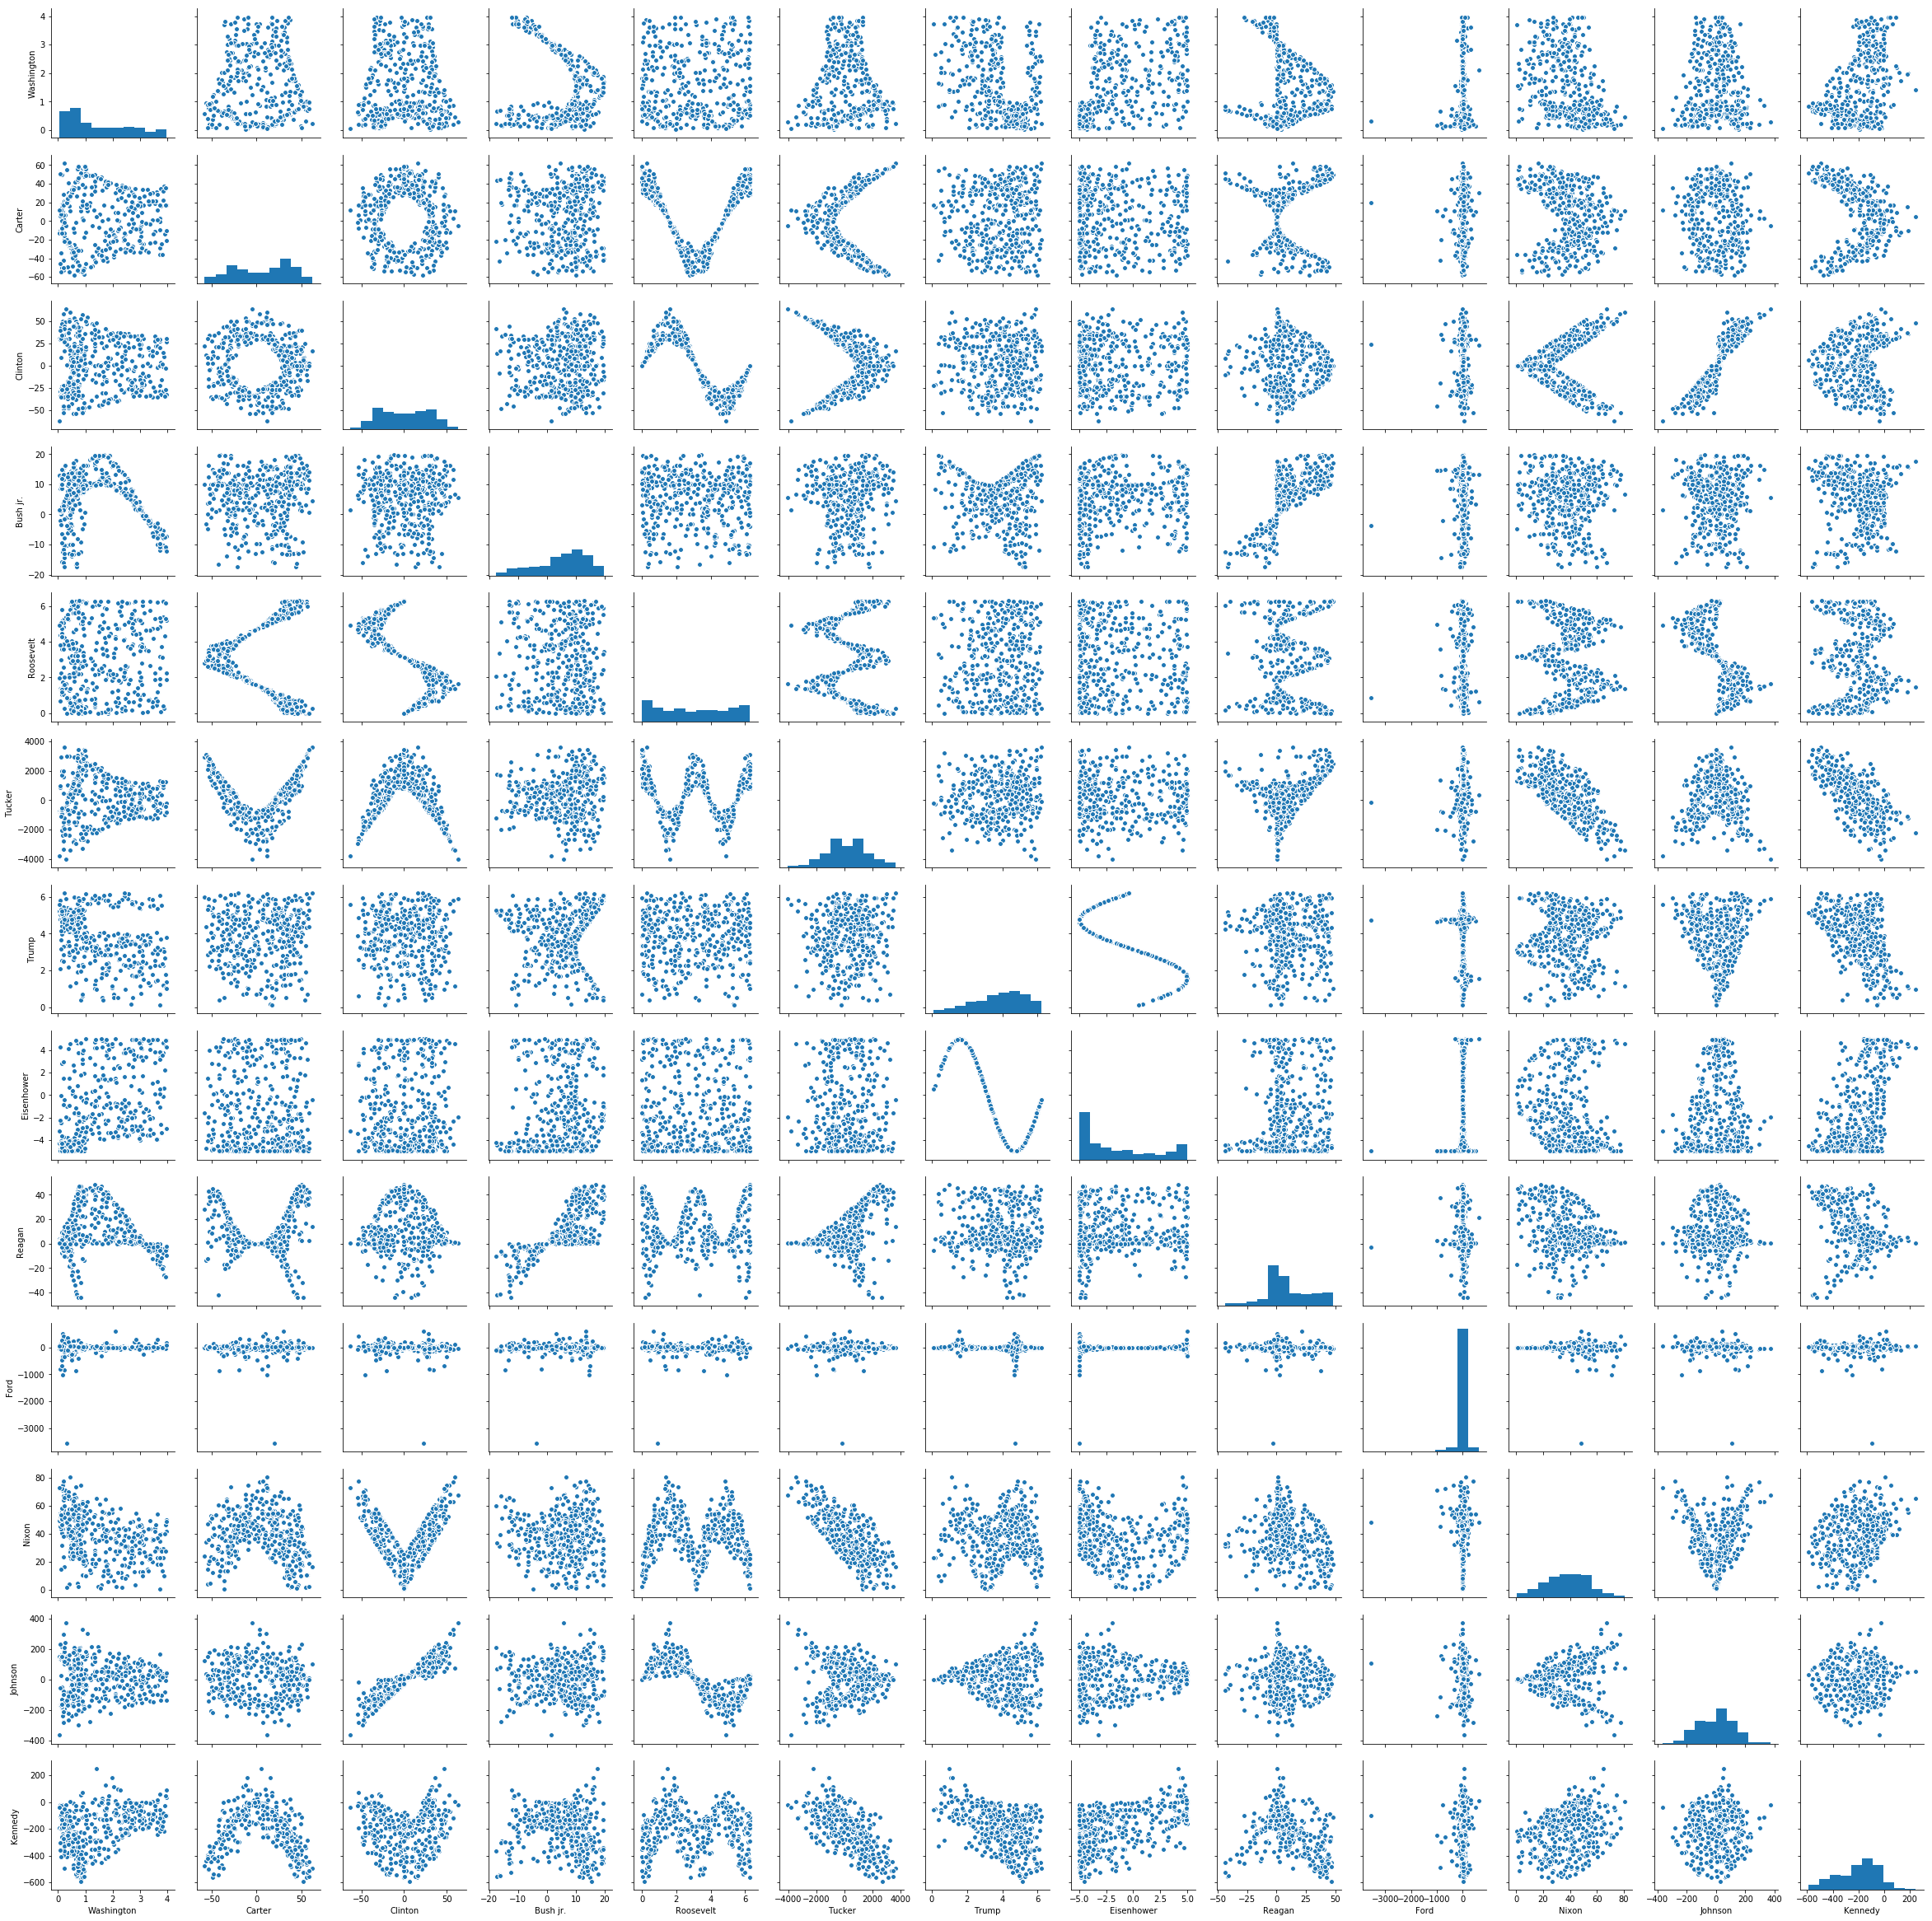

In [279]:
sns.pairplot(data)
plt.show()

какие-то неестественные зависимости)

In [216]:
X, y = data.values[:, 1:], data.values[:, 0]

Отнормируем данные

In [137]:
scaler = StandardScaler()
X = scaler.fit_transform(X, y=y)

Возьмем 4 алгоритма понижения размерности и посмотрим на них качество линейной модели. Также будем варьировать количество компонент в этих алгоритмах

In [159]:
test_size = 0.3
random_state = 42
n_components_array = [2, 5, 7, 10, X.shape[1]]

algorithms = {
    "PCA": [PCA, {}],
    "PCA with cosine kernel": [KernelPCA, {"kernel": "cosine"}],
    "PCA with RBF kernel": [KernelPCA, {"kernel": "rbf"}],
    "t-SNE": [TSNE, {"method": "exact"}]
}

for algo_name, algo_info in algorithms.items():
    algo_ = algo_info[0]
    algo_params = algo_info[1]
    for n_components in n_components_array:
        reg = Ridge()
        
        # without decomposition
        if n_components == X.shape[1]:
            X_decomp = X
        else:
            algo_params["n_components"] = n_components
            algo = algo_(**algo_params)
            X_decomp = algo.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(X_decomp, y, test_size=test_size, random_state=random_state)
        
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        rmse_ = rmse(y_pred, y_test)
        print("decomposition algo: {} --- n_components: {} --- rmse: {}".format(algo_name, n_components, rmse_))

decomposition algo: PCA --- n_components: 2 --- rmse: 1.0663323656198413
decomposition algo: PCA --- n_components: 5 --- rmse: 0.9103760694477274
decomposition algo: PCA --- n_components: 7 --- rmse: 0.7995128843712217
decomposition algo: PCA --- n_components: 10 --- rmse: 0.756157233016412
decomposition algo: PCA --- n_components: 12 --- rmse: 0.7513611186015671
decomposition algo: PCA with cosine kernel --- n_components: 2 --- rmse: 1.0448463376159203
decomposition algo: PCA with cosine kernel --- n_components: 5 --- rmse: 0.8927925088746224
decomposition algo: PCA with cosine kernel --- n_components: 7 --- rmse: 0.7381148678783265
decomposition algo: PCA with cosine kernel --- n_components: 10 --- rmse: 0.724707246357309
decomposition algo: PCA with cosine kernel --- n_components: 12 --- rmse: 0.7513611186015671
decomposition algo: PCA with RBF kernel --- n_components: 2 --- rmse: 1.0460754774252055
decomposition algo: PCA with RBF kernel --- n_components: 5 --- rmse: 0.881190772610

Луше всех себя показал KernelPCA с косинусной мерой. На самом деле и ниже, этот алгоритм дает одни из самых лучших результатов

## Задача 4

In [192]:
data = fetch_olivetti_faces()

In [193]:
images = data["images"]
target = data["target"]
data = data["data"]

In [194]:
unique_target, unique_idx = np.unique(target, return_index=True)

In [195]:
len(unique_idx)

40

Посмотрим на изначальные картинки

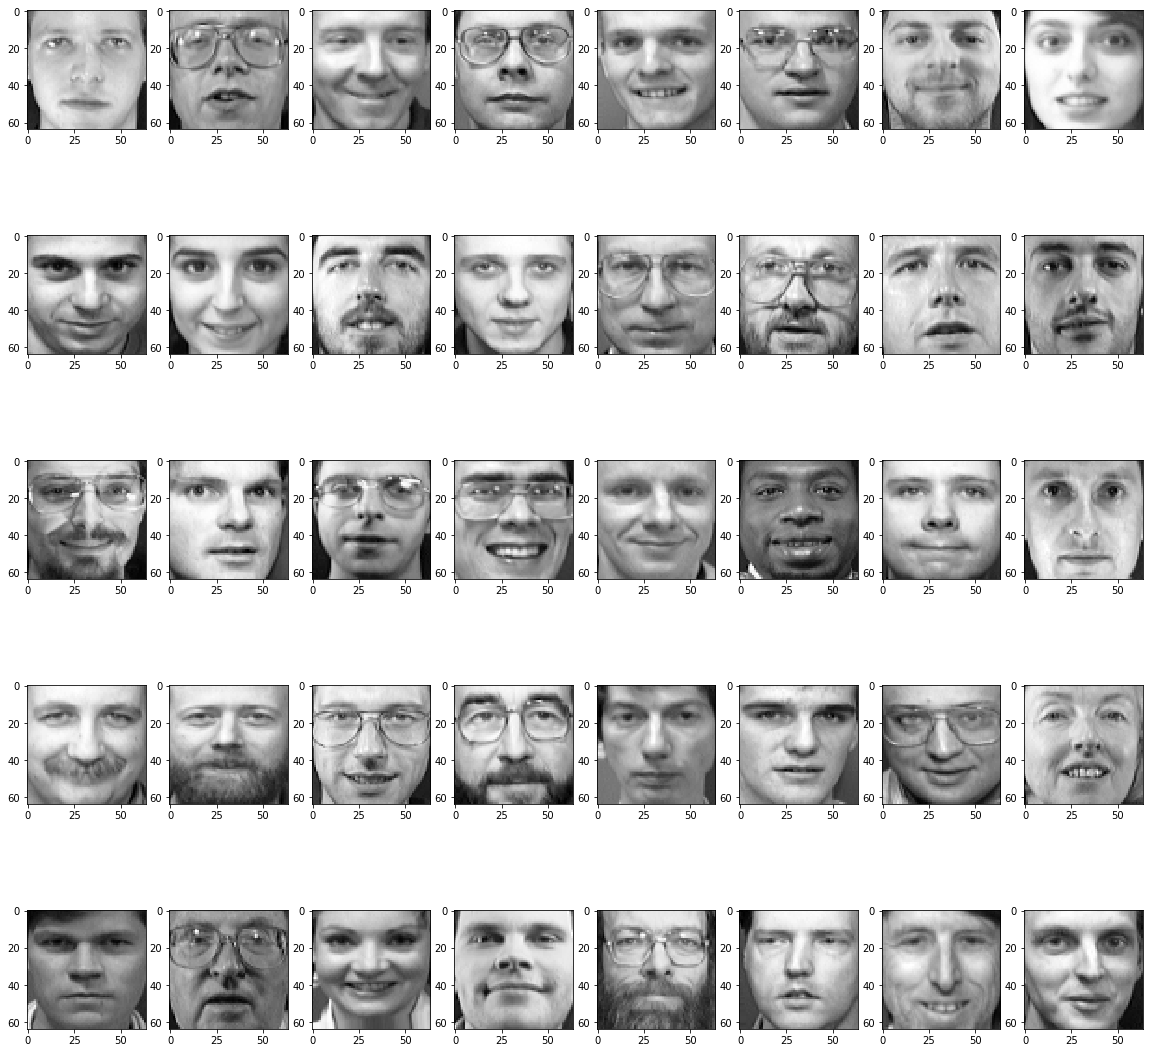

In [196]:
plt.figure(figsize=(20, 20))
for i, idx in enumerate(unique_idx):
    plt.subplot(5, 8, i + 1)
    plt.imshow(images[idx], cmap="gray")
plt.show()

Спроецируем изображения на пространство, натянутое на k главных компонент. Будем смотреть на те же 40 уникальных лиц

                                     PCA with n_components = 4                                      


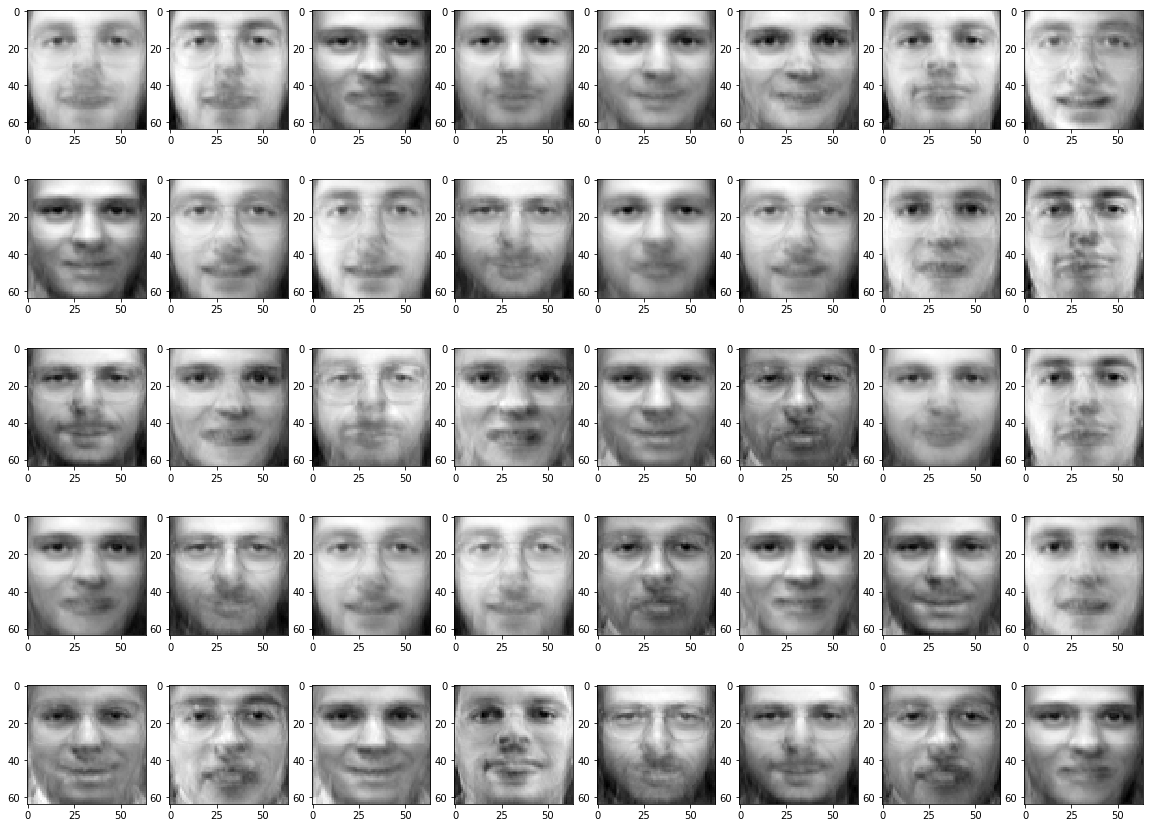

                                     PCA with n_components = 8                                      


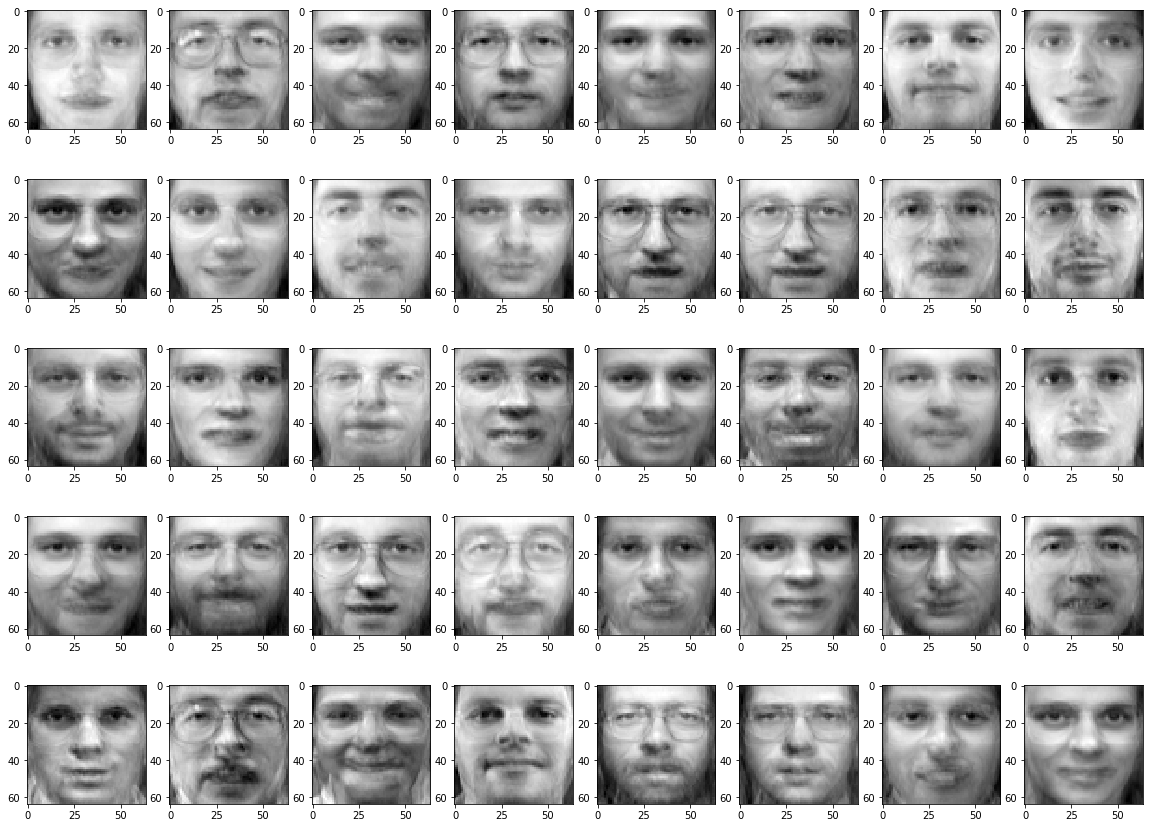

                                     PCA with n_components = 16                                     


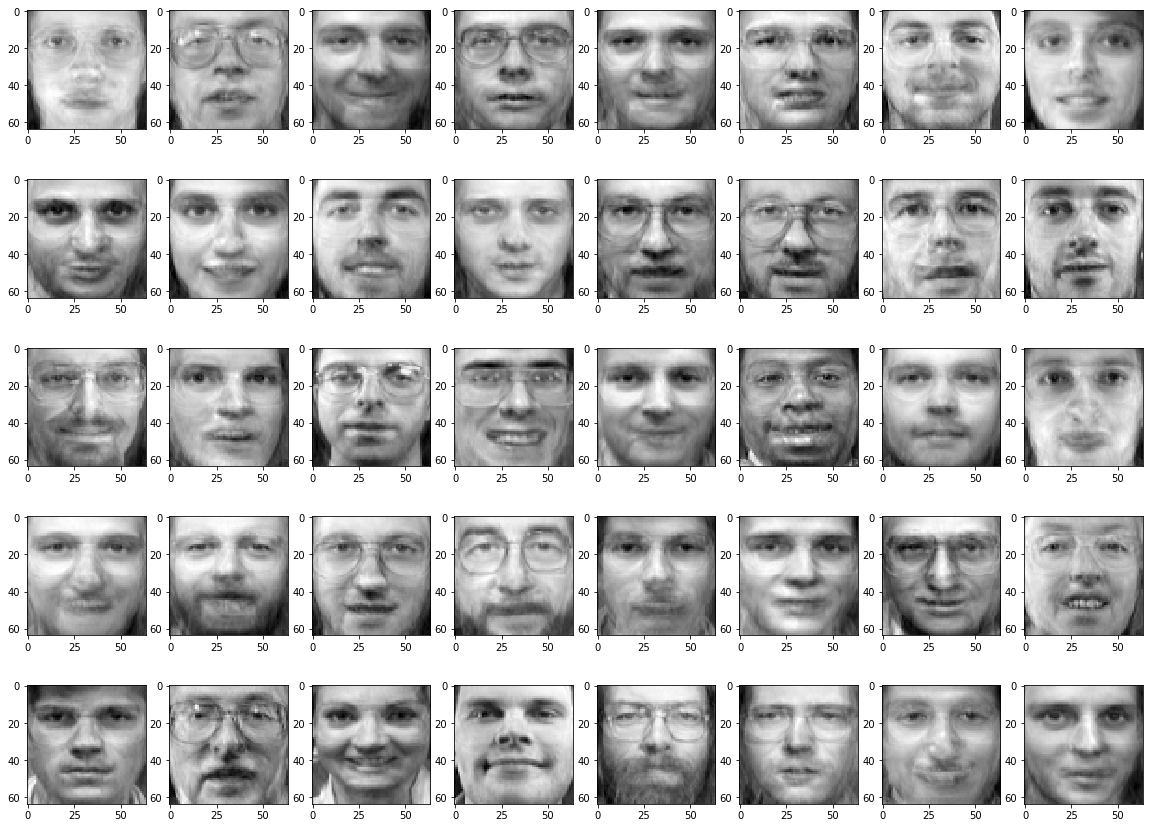

                                     PCA with n_components = 32                                     


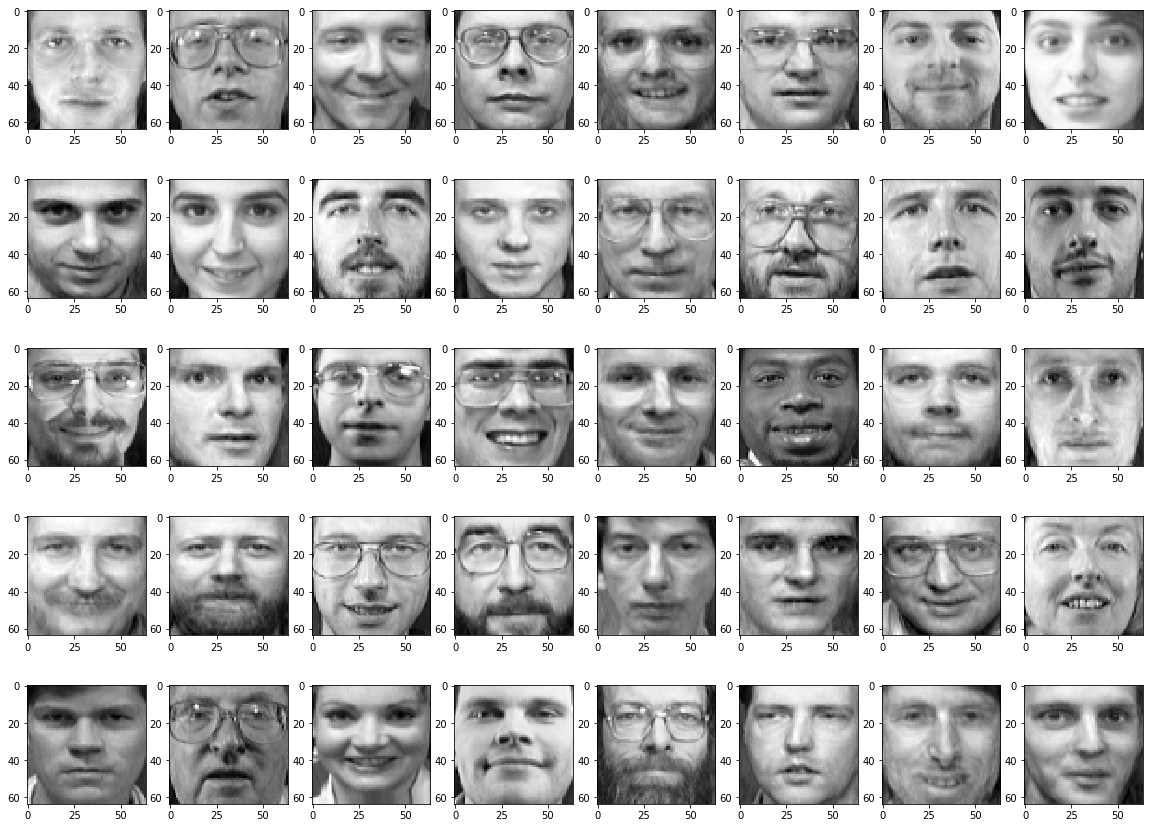

                                     PCA with n_components = 64                                     


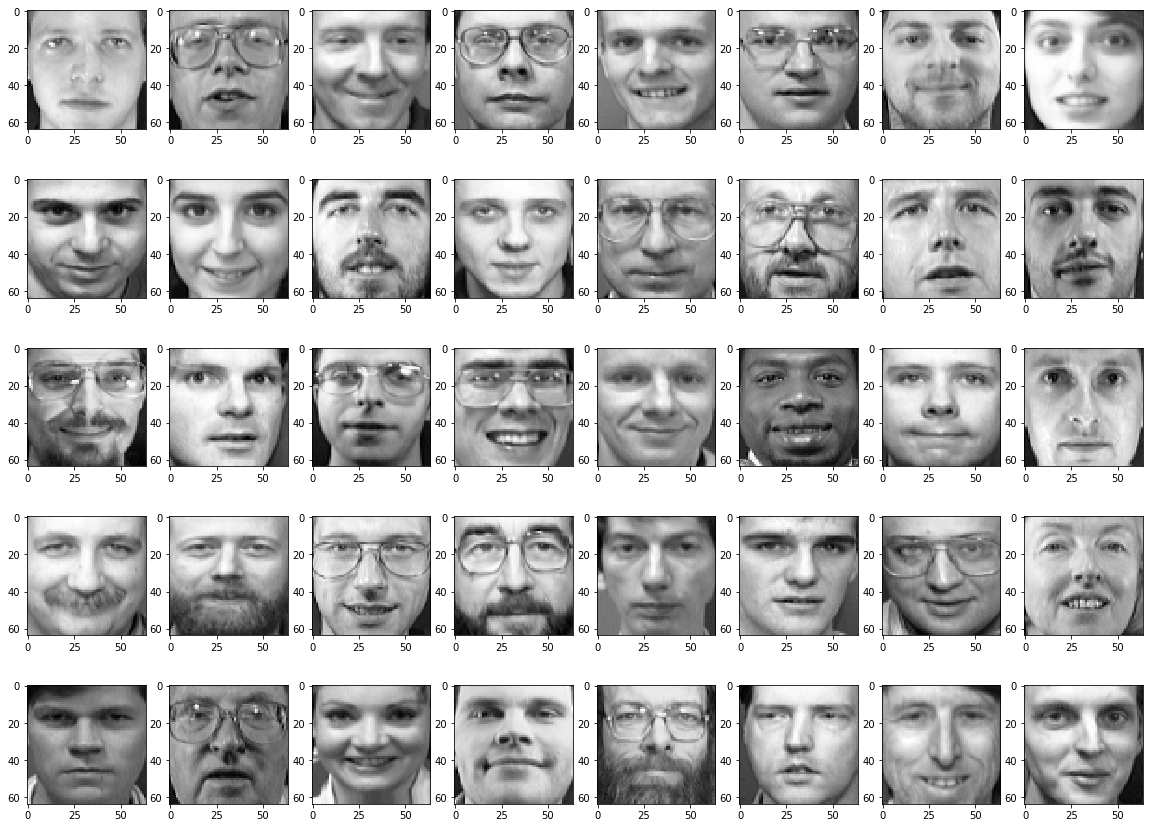

                                    PCA with n_components = 512                                     


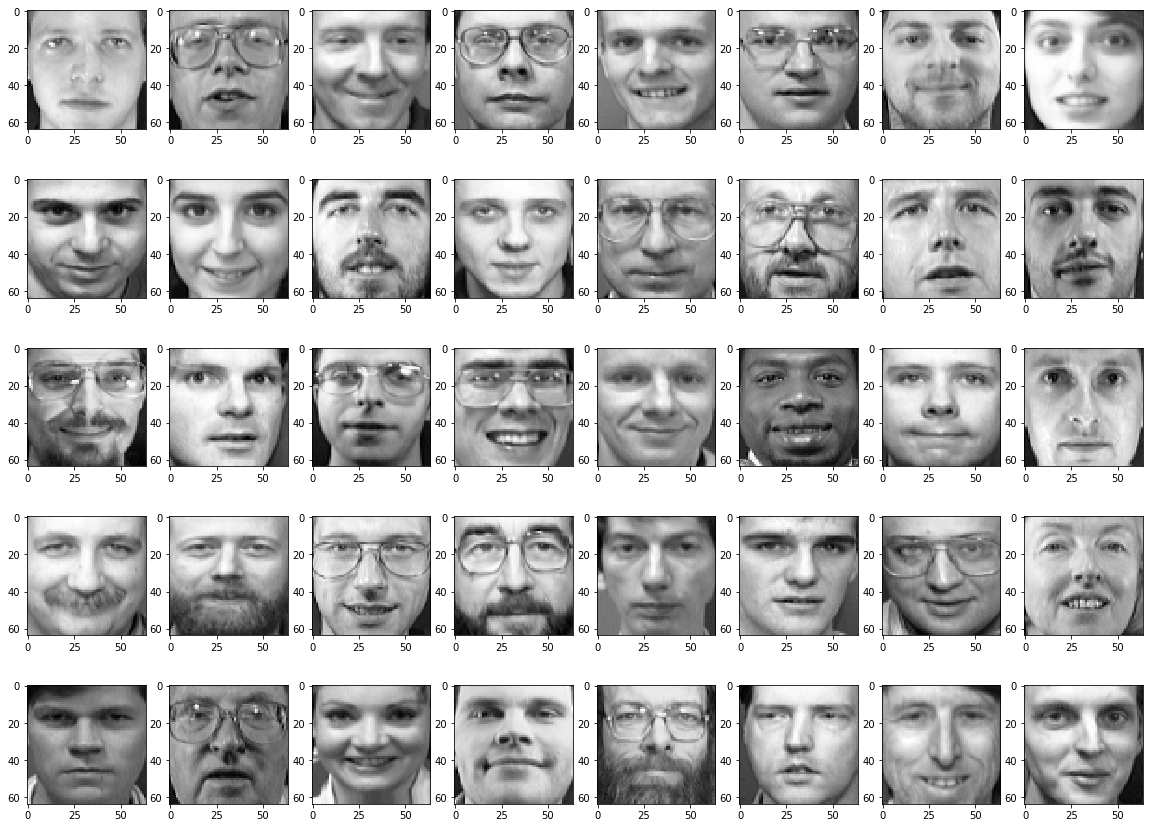

In [209]:
unique_data = data[unique_idx]
k_array = [4, 8, 16, 32, 64, 512]
for k in k_array:
    pca = PCA(n_components=k)
    pca_data = pca.fit_transform(unique_data)
    inverse_data = pca.inverse_transform(pca_data)
    print("{:=^100}".format("="))
    print("{:^100}".format("PCA with n_components = {}".format(k)))
    plt.figure(figsize=(20, 15))
    for i, img in enumerate(inverse_data):
        img = img.reshape(64, 64)
        plt.subplot(5, 8, i + 1)
        plt.imshow(img, cmap="gray")
    plt.show()

**Вывод:**

Отличия начинаю стираться при $k = 32$. При $k = 64$ лица хорошо различимы, при $k = 4$ лица практически неразличимы

### Спроецируем на $\mathbb{R}^2$:

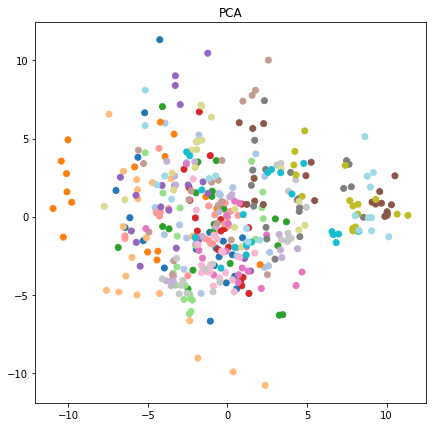

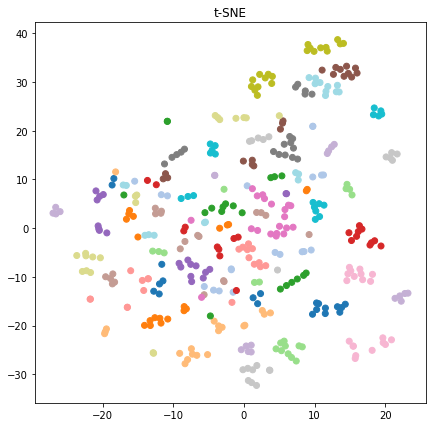

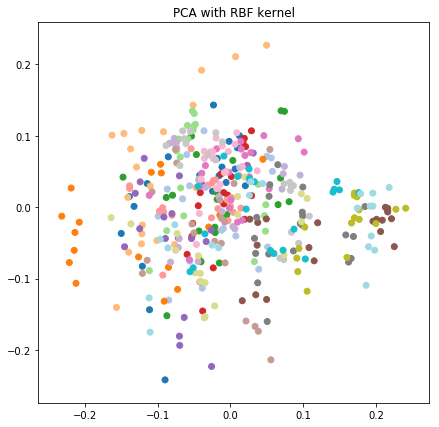

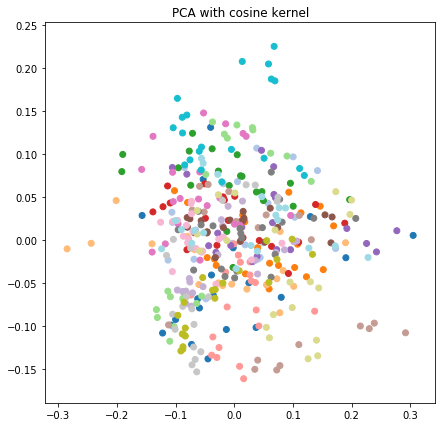

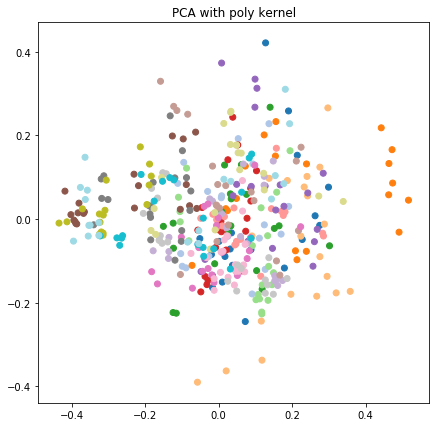

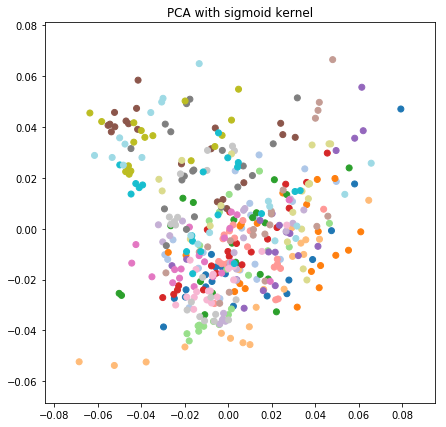

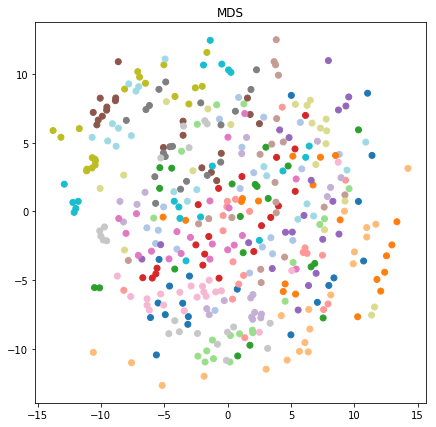

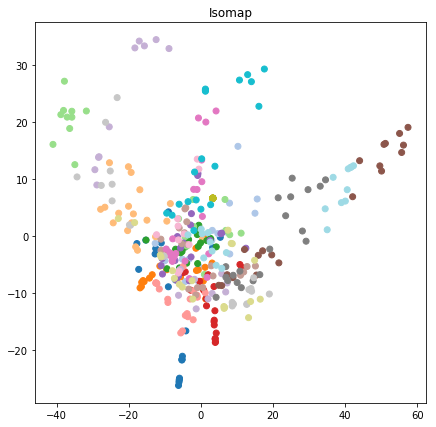

In [127]:
algorithms = {
    "PCA": [PCA(n_components=2)],
    "t-SNE": [TSNE(n_components=2)],
    "PCA with RBF kernel": [KernelPCA(n_components=2, kernel="rbf")],
    "PCA with cosine kernel": [KernelPCA(n_components=2, kernel="cosine")],
    "PCA with poly kernel": [KernelPCA(n_components=2, kernel="poly")],
    "PCA with sigmoid kernel": [KernelPCA(n_components=2, kernel="sigmoid")],
    "MDS": [MDS(n_components=2)],
    "Isomap": [Isomap(n_components=2)]
}

for algo_name, algo_params in algorithms.items():
    algo = algo_params[0]
    data_r2 = algo.fit_transform(data)
    plt.figure(figsize=(7, 7))
    plt.scatter(data_r2[:, 0], data_r2[:, 1], c=target, cmap="tab20")
    plt.title(algo_name)
    plt.show()

t-SNE очевидно победил. Победу его я бы его обоновал тем, что алгоритм сам по себе очень мощен и очень хорошо себя зарекомендовал в визуализации данных


## Задача 5

In [210]:
data = pd.read_csv('./data/hw11t5.csv', index_col=0)
data[:3]

0           1         2         3         4         5         6  \
0  3.0  154.821499  5.782582 -3.918036 -1.400880  3.945351  2.815372   
1  3.0   70.860971  3.590312 -0.640982  8.150033  0.770168 -7.692933   
2  3.0   57.396471  2.232988  0.017323  4.791453  0.020102  0.555192   

          7         8         9         10        11        12            13  \
0  0.403212 -0.993077  0.191118 -12.357041  0.197025 -5.040347  1.056376e+25   
1  1.272137 -0.832262  0.211284   1.679167 -0.992891  0.838220  9.920627e+03   
2 -5.698161  0.861783 -0.053746   1.403360  0.094688  9.101261  1.381784e+00   

         14         15  
0  0.946656 -80.043312  
1  0.997701   8.345960  
2 -0.288042  53.346486

decomposition: PCA, knn accuracy: 63.00 %
decomposition: t-SNE, knn accuracy: 70.67 %
decomposition: PCA with RBF kernel, knn accuracy: 40.67 %
decomposition: PCA with cosine kernel, knn accuracy: 64.67 %
decomposition: MDS, knn accuracy: 37.67 %
decomposition: Isomap, knn accuracy: 44.00 %


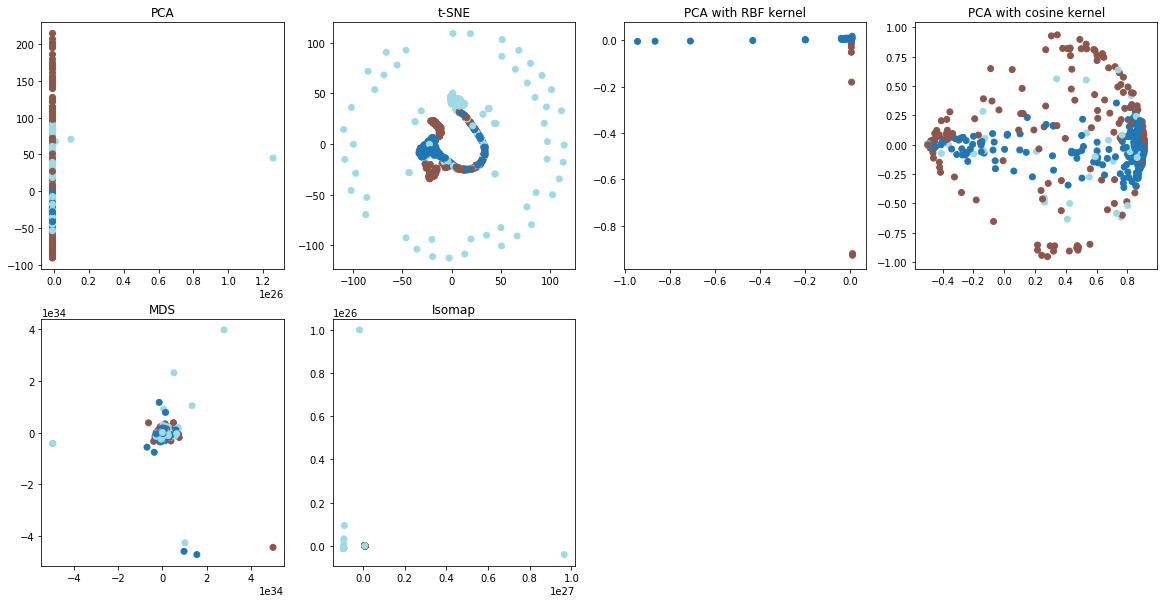

In [129]:
algorithms = {
    "PCA": [PCA(n_components=2)],
    "t-SNE": [TSNE(n_components=2)],
    "PCA with RBF kernel": [KernelPCA(n_components=2, kernel="rbf")],
    "PCA with cosine kernel": [KernelPCA(n_components=2, kernel="cosine")],
    "MDS": [MDS(n_components=2)],
    "Isomap": [Isomap(n_components=2)]
}

plt.figure(figsize=(20, 10))
for i, items in enumerate(algorithms.items()):
    algo_name, algo_params = items
    algo = algo_params[0]
    X, y = data.values[:, 1:], data.values[:, 0]
    X = algo.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    #train sample
    plt.subplot(2, 4, i + 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="tab20")
    plt.title(algo_name)
    
    #test sample
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    print("decomposition: {}, knn accuracy: {:.2f} %".format(algo_name, acc))
plt.show()

А вот тут мы видим, что посоперничать с t-SNE может PCA с косинусным ядром. В ходе экспиремента то тот, то другой алгоритм выходили вперед по качеству.

Проблема других алгоритмов заключалась в выбросах в выборке.

In [213]:
data.describe()

0            1            2            3            4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      1.970000    91.229888     4.199185    -0.014808     3.248896   
std       0.825701    58.167060     1.253185     2.138914     5.241760   
min       1.000000     0.895483     0.331931    -5.900755    -9.725361   
25%       1.000000    54.659985     3.316584    -1.357870    -0.476536   
50%       2.000000    75.572115     4.377548    -0.009941     4.212634   
75%       3.000000   115.380773     5.197345     1.329094     7.309513   
max       3.000000   317.549277     6.279979     6.097210    13.868179   

                 5            6            7            8            9  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      2.519094    -2.643790    -1.016344     0.004254     0.166774   
std       1.549501    49.192474     5.095105     0.723490     8.862615   
min       0.002099 -1372.122555   -11.304553    -1.000000   -90.730814   
25%       1.211617    -1.053976    -5.236417    -0.740384    -0.176108   
50%       2.338732    -0.101208    -0.680206    -0.017957    -0.025525   
75%       3.567729     0.817378     3.114384     0.741550     0.164289   
max       6.178685    63.410529     8.440347     1.000000   260.776874   

                10           11           12            13           14  \
count  1000.000000  1000.000000  1000.000000  1.000000e+03  1000.000000   
mean     -2.138368    -0.157690    -1.122752  7.931667e+23    -0.007098   
std       4.659183     0.752196    34.147307  2.013455e+25     0.849983   
min     -12.842630    -1.000000 -1031.521300  1.000002e+00    -1.000000   
25%      -5.396345    -0.913138    -0.954613  6.549730e+00    -0.961775   
50%      -1.526332    -0.345943    -0.084984  6.930766e+02    -0.018483   
75%       1.824511     0.597185     0.952022  4.553089e+05     0.934899   
max       6.771898     1.000000   165.031757  6.237491e+26     1.000000   

                15  
count  1000.000000  
mean     -4.253618  
std      41.075582  
min    -106.900832  
25%     -25.358752  
50%      -0.617321  
75%      20.066396  
max      93.878216

Действительно, видимо большой максимум в 13 столбце